### Library Import

In [1]:
import pandas as pd
import numpy as np
import os

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, \
    get_params_from_config, dailydf_to_ts, inverse_transform_minmax, transform_dayofyear, write_DWH
from models.lstm import simpleLSTM
from models.deeplearner import DeepLearner

from solutil import evaluations

### Input Preparation

In [2]:
# Define global variables
str_model = 'inlet1_lstm'

In [3]:
# Load Input Parameters
dates = get_dates_from_config(str_model)
df_variables = load_input(str_model=str_model, **dates)

base
base_1d
useday_1d
temp_1h
glob_1h
rain_1h
bf15_1h
schmelz_1h
rain_1h_prog
glob_1h_prog
temp_1h_prog


In [4]:
df_variables

,base_lag0,base_1d_lag0,temp_1h_lag0,temp_1h_lag1,glob_1h_lag1,glob_1h_lag2,glob_1h_lag3,rain_1h_lag0,rain_1h_lag1,bf15_1h_lag0,schmelz_1h_lag0,schmelz_1h_lag1,rain_1h_prog_lag-6,glob_1h_prog_lag-6,temp_1h_prog_lag-6
2021-03-02 00:00:00+01:00,1.575118,1.616138,3.485418,3.056250,0.000000,67.564583,471.766667,0.000000,0.000000,1.126800,0.056250,0.054175,0.0,0.00000,11.4300
2021-03-02 04:00:00+01:00,1.425177,1.616138,3.687498,3.485418,0.000000,0.000000,67.564583,0.000000,0.000000,1.123125,0.068350,0.056250,0.0,0.00000,11.4300
2021-03-02 08:00:00+01:00,1.275315,1.616138,6.229167,3.687498,7.622917,0.000000,0.000000,0.000000,0.000000,1.124425,0.086225,0.068350,0.0,0.00000,11.4300
2021-03-02 12:00:00+01:00,1.767134,1.616138,10.293768,6.229167,372.379167,7.622917,0.000000,0.000000,0.000000,1.112425,0.097900,0.086225,0.0,0.00000,11.4300
2021-03-02 16:00:00+01:00,1.832819,1.616138,7.958333,10.293768,492.562500,372.379167,7.622917,0.000000,0.000000,1.103950,0.080825,0.097900,0.0,0.00000,11.4300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-06 08:00:00+01:00,4.200000,4.200000,21.700000,17.327083,240.258333,1.281250,0.478125,0.000000,0.000000,1.002583,0.000000,0.000000,0.0,151.08125,15.2975
2024-07-06 12:00:00+01:00,4.200000,4.200000,18.222917,21.700000,670.275000,240.258333,1.281250,2.190417,0.000000,1.010354,0.000000,0.000000,0.0,224.84375,17.1925
2024-07-06 16:00:00+01:00,4.200000,4.200000,14.864583,18.222917,186.965625,670.275000,240.258333,2.447083,2.190417,1.170292,0.000000,0.000000,0.0,62.27500,16.6350
2024-07-06 20:00:00+01:00,4.200000,4.200000,12.775000,14.864583,53.510417,186.965625,670.275000,1.802083,2.447083,1.246417,0.000000,0.000000,0.0,0.18125,14.5350


In [5]:
df_doy = transform_dayofyear(df_variables)

There are some outliers in the data, as can be seen from the following plot.

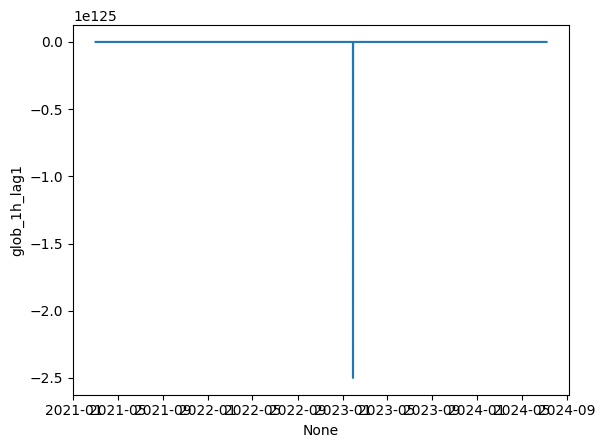

In [6]:
import seaborn as sns

fig = sns.lineplot(x=df_variables.index, y=df_doy['glob_1h_lag1'])

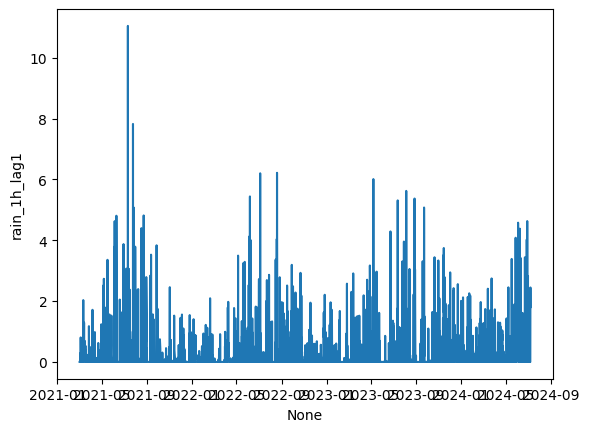

In [7]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['rain_1h_lag1'])

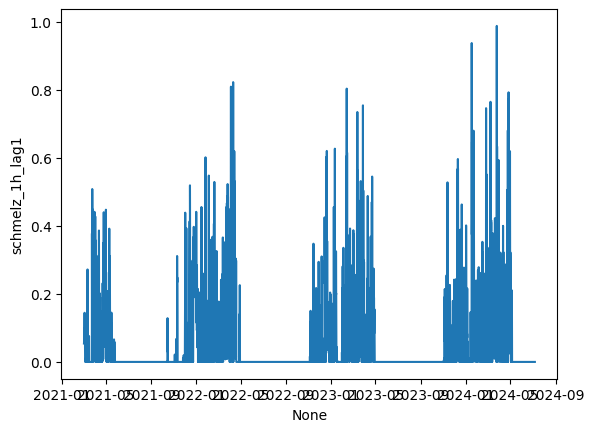

In [8]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['schmelz_1h_lag1'])

In [9]:
# Handle outliers
df_handled = handle_outliers(df_doy)

Variable base_lag0
Variable base_1d_lag0
Variable temp_1h_lag0
Variable temp_1h_lag1
Variable glob_1h_lag1
Variable glob_1h_lag2
Variable glob_1h_lag3
Variable rain_1h_lag0
Variable rain_1h_lag1
Variable bf15_1h_lag0
Variable schmelz_1h_lag0
Variable schmelz_1h_lag1
Variable rain_1h_prog_lag-6
Variable glob_1h_prog_lag-6
Variable temp_1h_prog_lag-6
Variable yearday_sin
Variable yearday_cos


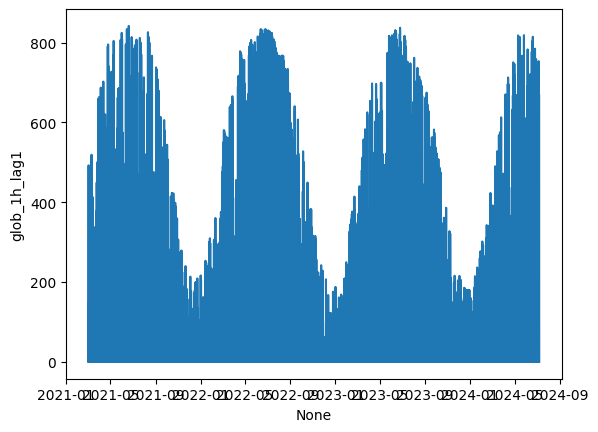

In [10]:
fig = sns.lineplot(x=df_handled.index, y=df_handled['glob_1h_lag1'])

In [11]:
# Scale inputs
df_scaled = scale_with_minmax(df_handled, str_model, verbose=0)

In [12]:
# Initialize lstm class
lstm = simpleLSTM()
deepl = DeepLearner()

In [13]:
# Generate sequences
n_lookback = 20
n_ahead = 6
n_offset = 0
target_var = 'base_lag0'

df_seq = lstm.generate_sequences(df_scaled, target_var, n_lookback, n_ahead, n_offset, continuous=False)

Length df_x: 7195 - length df_y: 7195


In [14]:
lstm.ytest_startdate

Timestamp('2023-07-13 08:00:00+0100', tz='Etc/GMT-1')

In [15]:
# Save variables
x_train = df_seq[0]
x_test = df_seq[1]
y_train = df_seq[2]
y_test = df_seq[3]

In [16]:
x_train.shape

(836, 20, 16)

### Model Initiation & Training

#### Grid Search

In [17]:
# Grid Search hyperparameters
hyperparams = {
    'units_l1': [100, 200],
    'units_l2': [100, 200],
    'dropout_l1': [0.1, 0.2],
    'dropout_l2': [0.1, 0.2],
    'activation_l1': ["sigmoid", "tanh"],
    'activation_l2': ['sigmoid', 'tanh']
}

lookback_periods = [84, 112]

lookback_dict = deepl.get_grid_train_dict(lookback_periods, df_scaled, target_var) # kwargs possible

Length df_x: 7195 - length df_y: 7195
Length df_x: 7195 - length df_y: 7195


In [18]:
#results, best_model, best_loss = deepl.grid_search_lstm(lookback_dict, hyperparams)

The optimum model is configured with the option 58, representing the following specifics: 

{'units_l2': 100,
 'units_l1': 200,
 'dropout_l2': 0.1,
 'dropout_l1': 0.2,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

In [19]:
# Retrieve optimal model parameters
from sklearn.model_selection import ParameterGrid
option_grid = ParameterGrid(hyperparams)
opt_config = option_grid[58]

In [20]:
lstm_2l = lstm.build_2layer_lstm(x_train, y_train, **opt_config) # lstm.build_2layer_bidirectional_lstm(x_train, y_train, **opt_config)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 200)             │         173,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,606 (1.12 MB)

 Trainable params: 294,606 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Train Final Model

In [21]:
# Get training parameters
train_params = get_params_from_config(function='model_train', str_model='inlet1_lstm')

In [22]:
# Train Model
trained_lstm, lstm_hist = deepl.train_model(x_train, y_train, lstm_2l, **train_params, verbose_int=1)

Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0856 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0541 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0409 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0396 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0324 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0302 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0303 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0278 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0257 - val_loss: 0.0186 - learning_rate: 0.0010
E

In [23]:
y_pred = trained_lstm.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


### Model Evaluation

In [24]:
# Rescale predictions
y_pred = inverse_transform_minmax(y_pred, 'inlet1_lstm', ['base_lag0'])
y_test = inverse_transform_minmax(y_test, 'inlet1_lstm', ['base_lag0']) 

In [25]:
# Convert prediction to df
start_date = None #'01.01.2024 00:00:00'
n_timestep = None # 1

df_ypred = lstm.convert_seq_to_df(y_pred, n_timestep=n_timestep, start_date=start_date)

In [26]:
# Convert test seq to df
df_ytest = lstm.convert_seq_to_df(y_test, start_date=start_date, n_timestep=n_timestep)

In [27]:
# Convert df to time series
ts_ypred = dailydf_to_ts(df_ypred)
ts_ytest = dailydf_to_ts(df_ytest)

In [28]:
# Calculate metrics
evaluations.get_eval_metrics(ts_ytest, ts_ypred)

{'mae': 0.3604990315103359,
 'mse': 0.3611495283861286,
 'rmse': 0.6009571768322004,
 'mape': 156224082385232.78,
 'non-na%': 1.0,
 'n_actual_obs': 2154,
 'n_pred_nas': 0}

<Axes: xlabel='time', ylabel='value'>

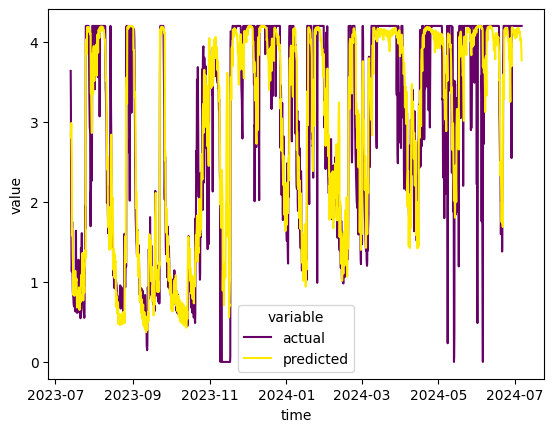

In [29]:
evaluations.get_act_vs_pred_plot(ts_ytest, ts_ypred)

### Results

#### EPAG RNN Benchmark model

The benchmark model performs as follows:

{'mae': 0.42552994824696827,
 'mse': 0.43365600821587413,
 'rmse': 0.6585256321631483,
 'mape': 0.42552994824696827,
 'non-na%': 1.0,
 'n_actual_obs': 28952,
 'n_pred_nas': 24}

#### 2-Layer LSTM, **28d lookback** period for 24h prediction, **zero-lag features**

The model performs slightly better than the benchmark EPAG RNN model, leading to the following metrics:

{'mae': 0.42610932601495455,
 'mse': 0.4287221795833913,
 'rmse': 0.6547687985719779,
 'mape': 0.42610932601495455,
 'non-na%': 1.0,
 'n_actual_obs': 2088,
 'n_pred_nas': 0}

The model was configured using the following specifications:

 {'units_l2': 100,
 'units_l1': 200,
 'dropout_l2': 0.1,
 'dropout_l1': 0.2,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

To derive these results, the following features were used:

- base_lag0
- base_1d_lag0
- temp_1h_lag0
- glob_1h_lag0
- rain_1h_lag0
- bf15_1h_lag0
- schmelz_1h_lag0

#### 2-Layer LSTM, **5d lookback** period for 24h prediction, **zero-lag features**

Compared to the longer-term models, the 5d lookback model (n_lookback = 20) **considerably outperforms**, yielding an improvement of 600 bps (expressed as mape decline). This looks highly promising, motivating further concentration on this model type.

{'mae': 0.36480787565215506,
 'mse': 0.32394114472592256,
 'rmse': 0.5691582773938393,
 'mape': 0.36480787565215506,
 'non-na%': 1.0,
 'n_actual_obs': 2118,
 'n_pred_nas': 0}

 The model specifications again were derived by using the following specifications:

{'units_l2': 100,
 'units_l1': 200,
 'dropout_l2': 0.1,
 'dropout_l1': 0.2,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

 To derive these results, the following features were used:

- base_lag0
- base_1d_lag0
- temp_1h_lag0
- glob_1h_lag0
- rain_1h_lag0
- bf15_1h_lag0
- schmelz_1h_lag0

#### 2-Layer LSTM, **4d lookback** period for 24h prediction, **zero-lag features**

Again, the 4d lookback model (n_lookback = 16) outperforms the more backward-looking models, however cannot manage to catch up to the 5d lookback model. 

{'mae': 0.42522474063231636,
 'mse': 0.4244721786739539,
 'rmse': 0.6515152942747806,
 'mape': 0.42522474063231636,
 'non-na%': 1.0,
 'n_actual_obs': 2118,
 'n_pred_nas': 0}

The model specifications again were derived by using the following specifications:

{'units_l2': 100,
 'units_l1': 200,
 'dropout_l2': 0.1,
 'dropout_l1': 0.2,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

 To derive these results, the following features were used:

- base_lag0
- base_1d_lag0
- temp_1h_lag0
- glob_1h_lag0
- rain_1h_lag0
- bf15_1h_lag0
- schmelz_1h_lag0

#### 2-Layer LSTM, **5d lookback** period for 24h prediction, **lagged features** with **offset**

With lagged features, the model still outperforms most other models across all metrics for a lookback period of 20, despite the offset period of 6*4h. This simulates performance under go-live conditions, indicating the model to be robust against the limitations of real-world use. The model's metrics look as follows:

{'mae': 0.36523608908083893,
 'mse': 0.31149900764815275,
 'rmse': 0.558120961484294,
 'mape': 0.36523608908083893,
 'non-na%': 1.0,
 'n_actual_obs': 2118,
 'n_pred_nas': 0}

 The model specifications were again derived by using the following specifications:

 {'units_l2': 100,
 'units_l1': 200,
 'dropout_l2': 0.1,
 'dropout_l1': 0.2,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

 To derive these results, the following features were used:

 - base_lag0
 - base_1d_lag0
 - temp_1h_lag1
 - glob_1h_lag1
 - glob_1h_lag2
 - glob_1h_lag3
 - rain_1h_lag1
 - rain_1h_lag2
 - rain_1h_lag3
 - bf15_1h_lag0
 - bf15_1h_lag1
 - bf15_1h_lag2
 - bf15_1h_lag3
 - schmelz_1h_lag1
 - schmelz_1h_lag2
 - schmelz_1h_lag3

#### 2-Layer LSTM, **20x lookback** period for 24h prediction, **lagged features + doy + prognosen** with **offset**

The difference to the model above is that the Prognosen on rain, global irradiation and temperature are included as separate features. This will alter the performance of the model slightly and depending on the training cycle, as the error metrics are minimally inflated or deflated, eventually oscillating around 0.36-0.37 across all cycles. The sample output presents itself as follows:

{'mae': 0.3606614881101602,
 'mse': 0.3505069093675864,
 'rmse': 0.5920362399106885,
 'mape': 142796200965146.16,
 'non-na%': 1.0,
 'n_actual_obs': 2130,
 'n_pred_nas': 0}

The model specification was:
{'units_l2': 100, 'units_l1': 200, 'dropout_l2': 0.1, 'dropout_l1': 0.2, 'activation_l2': 'tanh', 'activation_l1': 'tanh'}

Sample features were:
- Variable base_1d_lag0
- Variable temp_1h_lag0
- Variable temp_1h_lag1
- Variable glob_1h_lag1
- Variable glob_1h_lag2
- Variable glob_1h_lag3
- Variable rain_1h_lag0
- Variable rain_1h_lag1
- Variable bf15_1h_lag0
- Variable schmelz_1h_lag0
- Variable schmelz_1h_lag1
- Variable rain_1h_prog_lag-6
- Variable glob_1h_prog_lag-6
- Variable temp_1h_prog_lag-6
- Variable yearday_sin
- Variable yearday_cos

### Save Model Output for Ensemble

In [30]:

data_dict = {'ypred_lstm': ts_ypred,
            'ytest': ts_ytest}

df_data = pd.DataFrame(data_dict)

df_data.to_csv('experiments/stacking_data/ypred_lstm.csv')


In [31]:
df_variables.to_csv('experiments/stacking_data/features_lstm.csv')

### Save Model Output for Ensemble

In [32]:
# Interpolate to 1h frequency
ts_ypred_1h = ts_ypred.resample('1h').interpolate()
df_ypred_1h = ts_ypred_1h.to_frame()

In [33]:
# Create ts name string
inlet_n = str_model.split('_')[0].capitalize()
str_algo = str_model.split('_')[1].upper()
str_pred = 'Prediction'
ts_name = '_'.join([inlet_n, str_pred, str_algo])

In [34]:
ts_name

'Inlet1_Prediction_LSTM'

In [35]:
# Save as csv

write_DWH(str_path=os.path.join(r'\\srvedm11', 'Import', 'Messdaten', 'EPAG_Energie', 'DWH_EX_60'),
          str_tsname=ts_name,
          str_property="Python",
          str_unit='m/3',
          df_timeseries = df_ypred_1h
          )


True

In [38]:
ts_ypred

2023-07-13 08:00:00+01:00    2.870115
2023-07-13 12:00:00+01:00    2.806063
2023-07-13 16:00:00+01:00    2.881666
2023-07-13 20:00:00+01:00    2.986994
2023-07-14 00:00:00+01:00    2.725491
                               ...   
2024-07-05 12:00:00+01:00    4.026597
2024-07-05 16:00:00+01:00    4.041140
2024-07-05 20:00:00+01:00    3.972046
2024-07-06 00:00:00+01:00    3.886039
2024-07-06 04:00:00+01:00    3.771173
Freq: 4h, Name: value, Length: 2154, dtype: float64